In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from PIL import Image
import cv2
import swifter
import pickle
from dataclasses import dataclass, field
from swifter import set_defaults
set_defaults(
    npartitions=None,
    dask_threshold=1,
    scheduler="processes",
    progress_bar=False,
    progress_bar_desc=None,
    allow_dask_on_strings=False,
    force_parallel=False,
)

In [3]:
root = Path().cwd().parent
data = root / 'data' / 'MO' / 'mo-images'

In [8]:
data_dict = {"species": [], "image": []}
for dir in data.iterdir():
    species = dir.name
    for file in dir.iterdir():
        data_dict["species"].append(species)
        data_dict["image"].append(file.name)

In [12]:
data_df = pd.DataFrame(data_dict)
data_df['file_path'] = data_df.apply(lambda x: str(data / x['species'] / x['image']), axis=1)
data_df.rename(columns={'image': 'file_name'}, inplace=True)

## Get Images Heights & Widths

In [14]:
def get_shape_pil(fname):
    img=Image.open(fname)
    return (img.size[0], img.size[1])

In [27]:
hw = data_df['file_path'].apply(get_shape_pil)
data_df = pd.concat([data_df, pd.DataFrame(hw.to_list(), columns=['width', 'height'])], axis=1)
data_df

In [43]:
class_dict = pickle.load(open(root / 'training' / 'data' / 'class_dict_full.pkl', 'rb'))
new_cd = {v:k for k,v in class_dict.items()}

In [66]:
data_df['class_id'] = data_df['species'].map(new_cd)
data_df = data_df[data_df['species'] != 'Non-Diagnostic']

isna = data_df[data_df['class_id'].isna()]
isna['class_id'] = isna.groupby("species").ngroup()
isna['class_id'] = isna['class_id'] + 7178

clsdict = isna.groupby("class_id")['species'].first().to_dict()
class_dict.update(clsdict)
pickle.dump(class_dict, open(root / 'training' / 'data' / 'class_dict_newest.pkl', 'wb'))

/tmp/ipykernel_9700/4155689283.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isna['class_id'] = isna.groupby("species").ngroup()
/tmp/ipykernel_9700/4155689283.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isna['class_id'] = isna['class_id'] + 7178


In [74]:
data_df['class_id'] = data_df['class_id'].fillna(isna['class_id'])
data_df['class_id'] = data_df['class_id'].astype(int)
data_df.reset_index(inplace=True, drop=True)
data_df.to_csv(root / 'training' / 'data' / 'mo-images.csv', index=False)

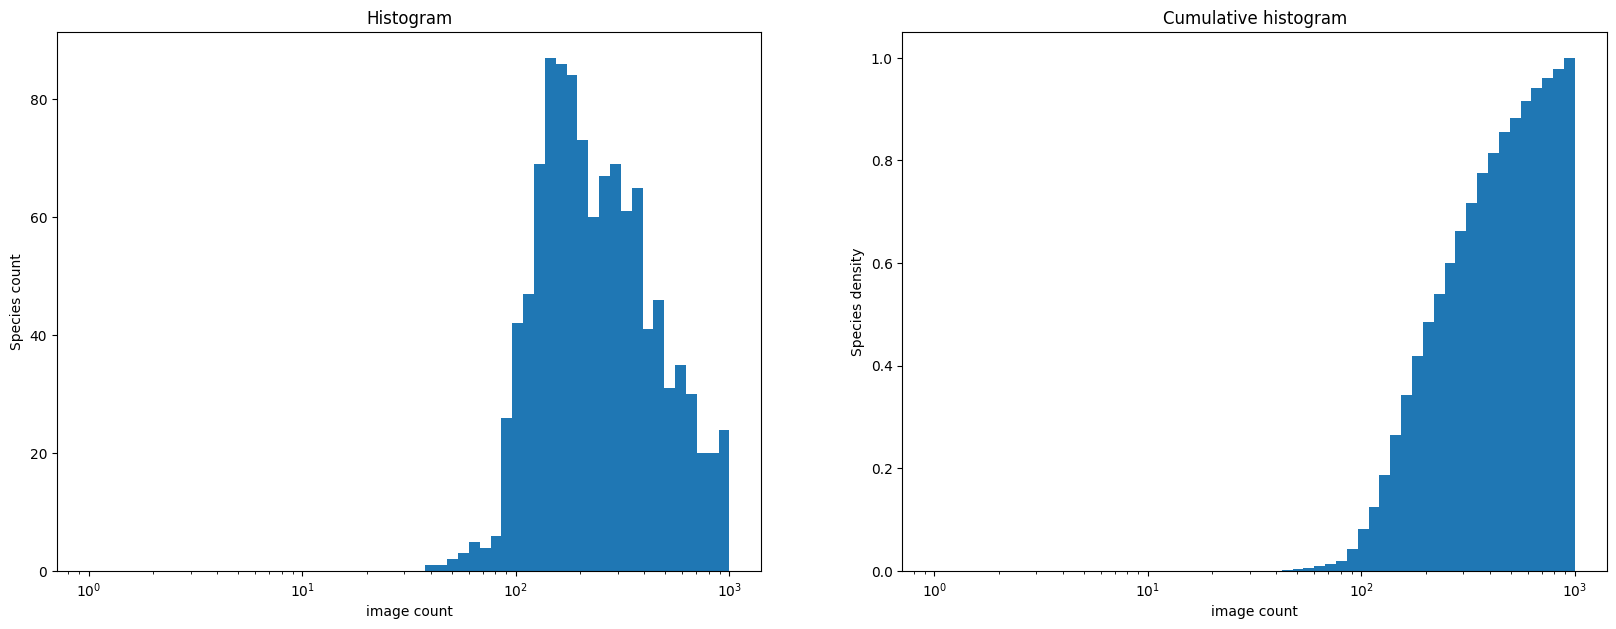

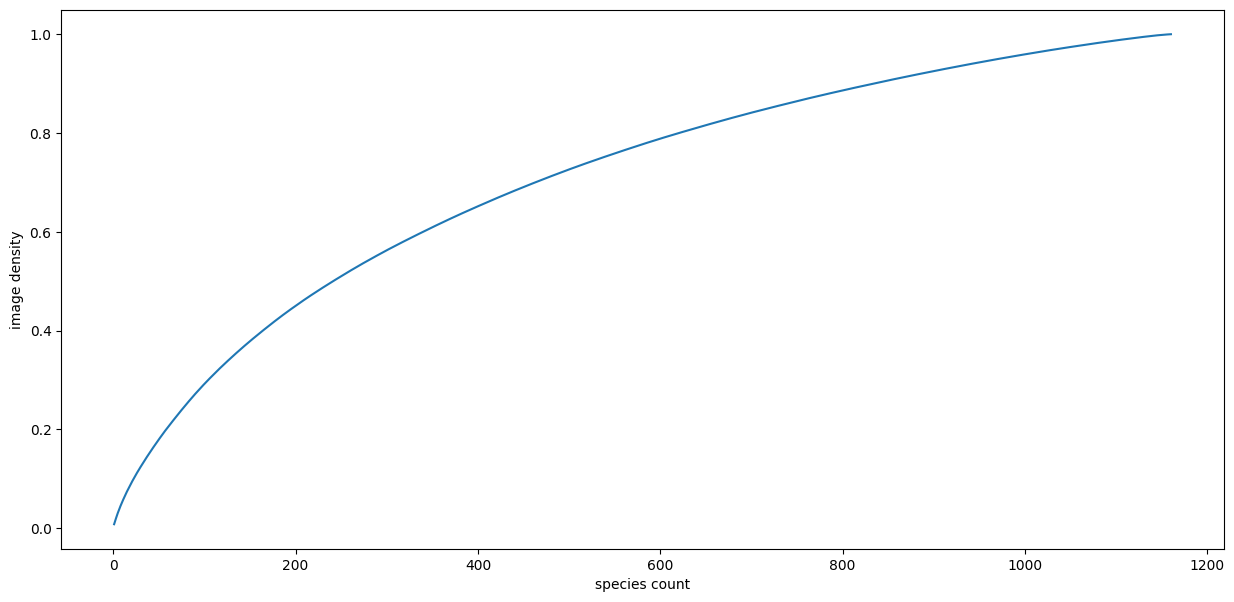

In [103]:
species2counts = data_df.groupby("species").count().sort_values("file_name")
to_plot = species2counts["file_name"].values

species2counts2 = data_df.groupby("species").count().sort_values("file_name", ascending=False)
to_plot2 = species2counts2["file_name"].values

fig, ax = plt.subplots(1, 2, figsize=(20, 7))

ax[0].hist(to_plot, bins=np.logspace(0, 3, num=60))
ax[1].hist(to_plot, bins=np.logspace(0, 3, num=60), cumulative=True, density=True)
for a in ax.flatten():
    a.set_xlabel("image count")
    a.set_xscale('log')
ax[0].set_title("Histogram"), ax[1].set_title("Cumulative histogram")
ax[0].set_ylabel("Species count"), ax[1].set_ylabel("Species density")

plt.show()

fig = plt.figure(figsize=(15, 7))

plt.plot(np.arange(len(to_plot2)) + 1, to_plot2.cumsum() / to_plot2.sum())
plt.xlabel("species count")
plt.ylabel("image density")

plt.show()

In [105]:
@dataclass
class ImageRowData:
    column1: tuple[str, str] = field(default_factory=tuple)
    column2: tuple[str, str] = field(default_factory=tuple)
    column3: tuple[str, str] = field(default_factory=tuple)
    column4: tuple[str, str] = field(default_factory=tuple)
    column5: tuple[str, str] = field(default_factory=tuple)

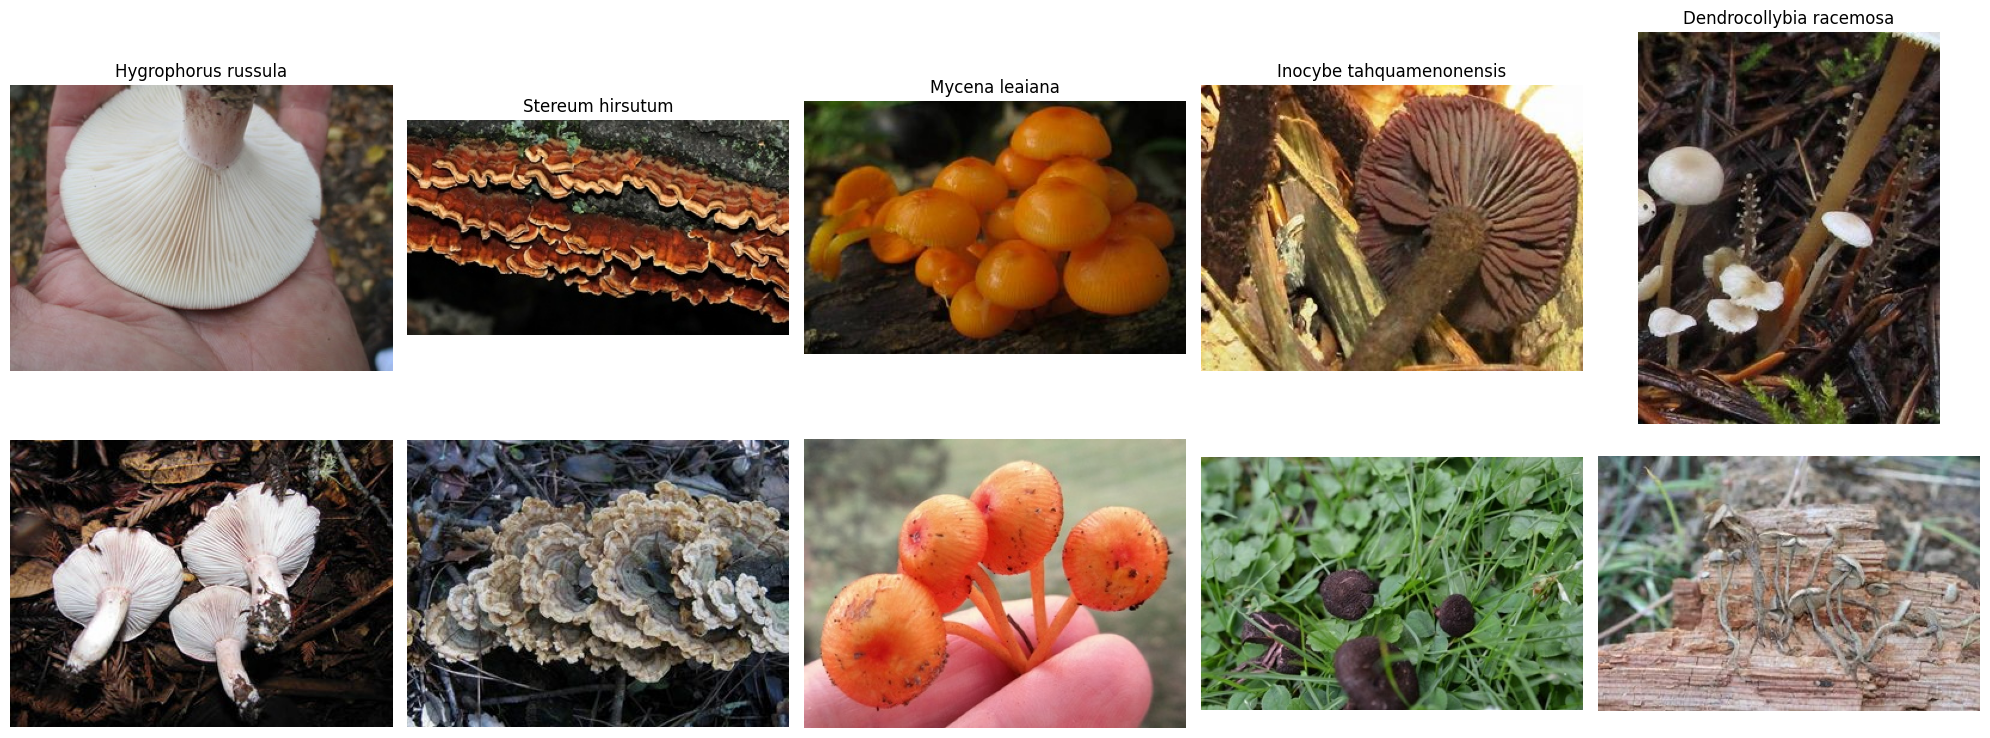

In [140]:
plt.figure(figsize=(20, 8))

classes = data_df['species'].sort_values().sample(5)
col_data = ImageRowData()

for i, cls in enumerate(classes, start=1):
    imgs = data_df[data_df['species'] == cls].sample(2)['file_path'].values.tolist()
    setattr(col_data, f'column{i}', (imgs[0], imgs[1]))

    for j, img in enumerate(imgs):
        im = cv2.imread(str(img))
        gray_im = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)
        clr_im = cv2.cvtColor(im, cv2.COLOR_RGB2BGR)
        gray = gray_im.reshape(-1)
        im = clr_im.reshape(-1, 3)

        plt.subplot(2, 5, i + (j * 5))
        if j == 0:
            plt.gca().set_title(f"{cls}")
        plt.axis('off')
        plt.imshow(clr_im)
plt.tight_layout()

In [143]:
file_list = []
for dir in data.iterdir():
    for file in dir.iterdir():
        file_list.append(str(file))

In [148]:
dels = set(file_list) - set(data_df['file_path'].values.tolist())

In [152]:
data_df[data_df['species'] == "Daedalea quercina"]

,species,file_name,file_path,width,height,class_id
0,Daedalea quercina,607849.jpg,/home/broug/Desktop/Mushroom-Classifier/data/M...,320,192,1995
1,Daedalea quercina,864707.jpg,/home/broug/Desktop/Mushroom-Classifier/data/M...,320,240,1995
2,Daedalea quercina,1519488.jpg,/home/broug/Desktop/Mushroom-Classifier/data/M...,320,240,1995
3,Daedalea quercina,139235.jpg,/home/broug/Desktop/Mushroom-Classifier/data/M...,320,240,1995
4,Daedalea quercina,1230024.jpg,/home/broug/Desktop/Mushroom-Classifier/data/M...,320,240,1995
...,...,...,...,...,...,...
558,Daedalea quercina,1395663.jpg,/home/broug/Desktop/Mushroom-Classifier/data/M...,320,240,1995
559,Daedalea quercina,145531.jpg,/home/broug/Desktop/Mushroom-Classifier/data/M...,320,240,1995
560,Daedalea quercina,1017461.jpg,/home/broug/Desktop/Mushroom-Classifier/data/M...,320,256,1995
561,Daedalea quercina,1311648.jpg,/home/broug/Desktop/Mushroom-Classifier/data/M...,240,320,1995


In [156]:
for file in dels:
    Path(file).unlink()
Path('/home/broug/Desktop/Mushroom-Classifier/data/MO/mo-images/Non-Diagnostic').rmdir()

In [165]:
df = pd.read_csv('/home/broug/Desktop/Mushroom-Classifier/training/data/train_full.csv')
df = df.drop(df[df['dataset'] == 'MO'].index)
df = df.reset_index(drop=True)

/tmp/ipykernel_9700/1239693373.py:1: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/home/broug/Desktop/Mushroom-Classifier/training/data/train_full.csv')


In [167]:
data_df = data_df.rename({"species": "name"}, axis=1)

In [171]:
df = pd.concat([df, data_df], axis=0).reset_index(drop=True)

In [175]:
df['dataset'] = df['dataset'].fillna("MO")
df['dataset'].replace({2021: "2021", 2018: "2018", 2019: "2019"}, inplace=True)

In [178]:
df.isna().sum()
df = df.dropna(axis=1)
df.to_csv('/home/broug/Desktop/Mushroom-Classifier/training/data/train_with_MO.csv', index=False)

In [185]:
df['class_id'] = df.groupby("name").ngroup()
class_dict = df.groupby("class_id")['name'].first().to_dict()
pickle.dump(class_dict, open(root / 'training' / 'data' / 'class_dict_NEW.pkl', 'wb'))